# H2030GC GIAB Pilot Study
This notebook generates Figure 1 and Figure 2 of the manuscript

In [19]:
import pandas as pd
import numpy as np
import os

In [20]:
sample_list = ['HG001', 'HG002', 'HG003', 'HG004']
platforms_dict = {'ultima':'results_happy_ultima_30x', 'illumina':'results_happy_illumina'}

In [ ]:
# set path to the hap.py results
basedir = 'data'

platform = 'illumina'
platform_dir = platforms_dict[platform]
sample = sample_list[1]

In [22]:
df_list = []

exclude = ['_AT_', '_GC_']

# Create regex pattern joining list items with |
pattern = '|'.join(exclude)

fields_to_select = ['Type', 'Subset','QUERY.TP','QUERY.FP','TRUTH.FN','QUERY.TOTAL','QUERY.UNK','METRIC.Precision','METRIC.Recall', 'METRIC.F1_Score']

for platform in platforms_dict.keys():
    for sample in sample_list:

        platform_dir = platforms_dict[platform]
        
        happy_df = pd.read_csv(os.path.join(basedir,platform_dir,sample+'.extended.csv'), sep=',')
        
        happy_hpol = happy_df[
            (happy_df['Filter'] == 'PASS') &
            (happy_df['Subtype'] == '*') &
            (happy_df['Subset'].str.contains('homopolymer')) &
            (~happy_df['Subset'].str.contains(pattern, case=False, na=False))
        ][fields_to_select]
        
        happy_all = happy_df[
            (happy_df['Filter'] == 'PASS') &
            (happy_df['Subtype'] == '*') &
            (happy_df['Subset'] == '*')
        ][fields_to_select]
        
        df_to_save = pd.concat([happy_all, happy_hpol])
        df_to_save['platform'] = platform
        df_to_save['sample'] = sample
        df_list.append(df_to_save)

res = pd.concat(df_list)

subset_dict = {
    '*': 'All',
    'SimpleRepeat_homopolymer_4to6_slop5': 'hpol_4to6',
    'SimpleRepeat_homopolymer_7to11_slop5': 'hpol_7to11',
    'SimpleRepeat_homopolymer_ge12_slop5': 'hpol_gt11',
    'SimpleRepeat_homopolymer_ge21_slop5': 'hpol_gt20'
}

res['Subset'] = res['Subset'].replace(subset_dict)
res['Type'] = res['Type'].replace({'SNP':'SNVs', 'INDEL':'Indels'})


In [23]:
df_long = (
    res
    .melt(
        id_vars=["platform","sample", "Type", "Subset",
                 "QUERY.TP","QUERY.FP","TRUTH.FN","QUERY.TOTAL","QUERY.UNK"],
        value_vars=["METRIC.Precision","METRIC.Recall","METRIC.F1_Score"],
        var_name="metric",
        value_name="value"
    )
)

# Extract suffix after the dot
df_long["metric"] = df_long["metric"].str.split(".", n=1).str[1]

print(df_long.head())


  platform sample    Type      Subset  QUERY.TP  QUERY.FP  TRUTH.FN  \
0   ultima  HG001  Indels         All    423117     41710     57605   
1   ultima  HG001    SNVs         All   3230692      7419     24466   
2   ultima  HG001  Indels   hpol_4to6    118719      6168      9422   
3   ultima  HG001  Indels  hpol_7to11     92697      5755      7492   
4   ultima  HG001  Indels   hpol_gt11     55153     34071     43789   

   QUERY.TOTAL  QUERY.UNK     metric     value  
0       736374     271547  Precision  0.910268  
1      3748110     509999  Precision  0.997709  
2       188229      63342  Precision  0.950611  
3       133969      35517  Precision  0.941545  
4       170717      81493  Precision  0.618141  


In [24]:
df_long.dtypes

platform        object
sample          object
Type            object
Subset          object
QUERY.TP         int64
QUERY.FP         int64
TRUTH.FN         int64
QUERY.TOTAL      int64
QUERY.UNK        int64
metric          object
value          float64
dtype: object

In [25]:
df_stats = df_long[['platform', 'Type', 'Subset', 'metric', 'value']].copy()
df_stats = df_stats.groupby(['platform', 'Type', 'Subset', 'metric']).agg(['mean', 'std']).reset_index()

df_stats = df_stats.apply(lambda x: np.floor(x * 1000) / 1000 if np.issubdtype(x.dtype, np.number) else x)

outfile = f"H2030GC_GIAB_stats.csv"
df_stats.to_csv(outfile, sep=',')

In [26]:
df_stats

platform    Type      Subset     metric  value       
                                              mean    std
0   illumina  Indels         All   F1_Score  0.992  0.005
1   illumina  Indels         All  Precision  0.995  0.003
2   illumina  Indels         All     Recall  0.990  0.007
3   illumina  Indels   hpol_4to6   F1_Score  0.993  0.004
4   illumina  Indels   hpol_4to6  Precision  0.995  0.002
5   illumina  Indels   hpol_4to6     Recall  0.991  0.005
6   illumina  Indels  hpol_7to11   F1_Score  0.997  0.002
7   illumina  Indels  hpol_7to11  Precision  0.998  0.001
8   illumina  Indels  hpol_7to11     Recall  0.996  0.003
9   illumina  Indels   hpol_gt11   F1_Score  0.995  0.005
10  illumina  Indels   hpol_gt11  Precision  0.996  0.003
11  illumina  Indels   hpol_gt11     Recall  0.994  0.006
12  illumina  Indels   hpol_gt20   F1_Score  0.982  0.016
13  illumina  Indels   hpol_gt20  Precision  0.982  0.013
14  illumina  Indels   hpol_gt20     Recall  0.981  0.019
15  illumina    SNVs         All   F1_Score  0.996  0.001
16  illumina    SNVs         All  Precision  0.998  0.000
17  illumina    SNVs         All     Recall  0.994  0.002
18  illumina    SNVs   hpol_4to6   F1_Score  0.996  0.001
19  illumina    SNVs   hpol_4to6  Precision  0.998  0.000
20  illumina    SNVs   hpol_4to6     Recall  0.994  0.002
21  illumina    SNVs  hpol_7to11   F1_Score  0.998  0.001
22  illumina    SNVs  hpol_7to11  Precision  0.999  0.000
23  illumina    SNVs  hpol_7to11     Recall  0.997  0.001
24  illumina    SNVs   hpol_gt11   F1_Score  0.997  0.002
25  illumina    SNVs   hpol_gt11  Precision  0.998  0.001
26  illumina    SNVs   hpol_gt11     Recall  0.997  0.003
27  illumina    SNVs   hpol_gt20   F1_Score  0.994  0.005
28  illumina    SNVs   hpol_gt20  Precision  0.997  0.003
29  illumina    SNVs   hpol_gt20     Recall  0.991  0.009
30    ultima  Indels         All   F1_Score  0.880  0.008
31    ultima  Indels         All  Precision  0.900  0.007
32    ultima  Indels         All     Recall  0.861  0.010
33    ultima  Indels   hpol_4to6   F1_Score  0.930  0.004
34    ultima  Indels   hpol_4to6  Precision  0.945  0.003
35    ultima  Indels   hpol_4to6     Recall  0.916  0.005
36    ultima  Indels  hpol_7to11   F1_Score  0.925  0.005
37    ultima  Indels  hpol_7to11  Precision  0.933  0.006
38    ultima  Indels  hpol_7to11     Recall  0.917  0.004
39    ultima  Indels   hpol_gt11   F1_Score  0.547  0.021
40    ultima  Indels   hpol_gt11  Precision  0.594  0.019
41    ultima  Indels   hpol_gt11     Recall  0.507  0.023
42    ultima  Indels   hpol_gt20   F1_Score  0.201  0.024
43    ultima  Indels   hpol_gt20  Precision  0.382  0.018
44    ultima  Indels   hpol_gt20     Recall  0.136  0.020
45    ultima    SNVs         All   F1_Score  0.994  0.000
46    ultima    SNVs         All  Precision  0.997  0.000
47    ultima    SNVs         All     Recall  0.990  0.001
48    ultima    SNVs   hpol_4to6   F1_Score  0.994  0.000
49    ultima    SNVs   hpol_4to6  Precision  0.997  0.000
50    ultima    SNVs   hpol_4to6     Recall  0.990  0.001
51    ultima    SNVs  hpol_7to11   F1_Score  0.986  0.001
52    ultima    SNVs  hpol_7to11  Precision  0.989  0.000
53    ultima    SNVs  hpol_7to11     Recall  0.983  0.001
54    ultima    SNVs   hpol_gt11   F1_Score  0.914  0.006
55    ultima    SNVs   hpol_gt11  Precision  0.929  0.004
56    ultima    SNVs   hpol_gt11     Recall  0.900  0.008
57    ultima    SNVs   hpol_gt20   F1_Score  0.834  0.032
58    ultima    SNVs   hpol_gt20  Precision  0.865  0.030
59    ultima    SNVs   hpol_gt20     Recall  0.804  0.034

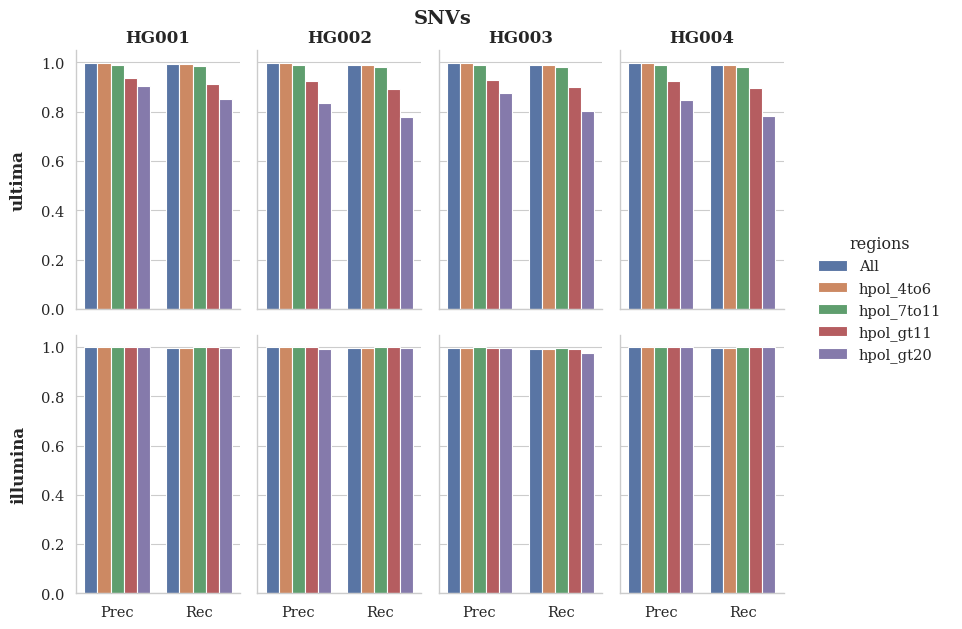

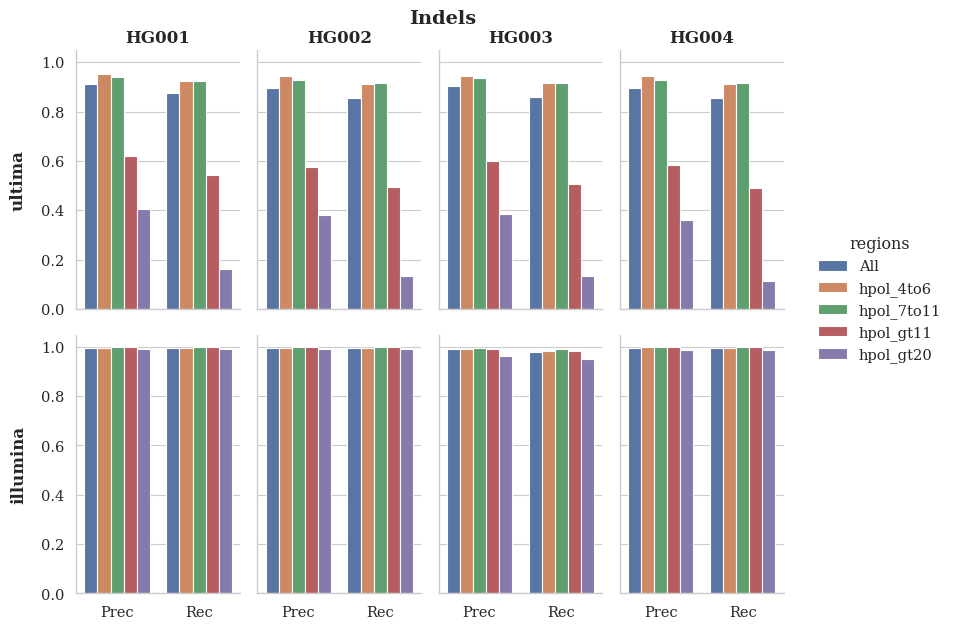

In [27]:
import seaborn as sns
import matplotlib.pyplot as plt

for variant_type in ['SNVs', 'Indels']:

    df_plot = df_long[df_long['Type']==variant_type].copy()
    df_plot = df_plot[df_plot["metric"].isin(["Precision", "Recall"])]
    df_plot.loc[:, "metric"] = df_plot["metric"].replace({"Precision": "Prec", "Recall": "Rec"})
    
    df_plot = df_plot.rename(columns={"Subset": "regions"})
    
    # Seaborn theme for small figures
    sns.set_theme(
        style="whitegrid",
        context="paper",       # small fonts suitable for print
        font="serif",
        font_scale=1.2         # slightly larger for readability
    )
    
    # Figure size: narrow for one-column width (~3.3 inches)
    fig_width = 3.3
    fig_height = 3.3 * len(df_plot["platform"].unique())  # scale by number of rows

    # print(df_plot)
    
    g = sns.catplot(
        data=df_plot,
        x="metric",
        y="value",
        hue="regions",
        row="platform",
        col="sample",
        kind="bar",
        height=fig_height / len(df_plot["platform"].unique()),
        aspect=fig_width / fig_height,
        dodge=True,
        legend="full" 
    )
    
    g._legend.set_bbox_to_anchor((1.2, 0.5)) 
    
    # Clean axis labels
    g.set_xlabels("")
    g.set_ylabels("")
    
    # Remove default facet titles
    for ax in g.axes.flat:
        ax.set_title("")
    
    # Set column titles only on top row
    for col_idx, col_name in enumerate(g.col_names):
        g.axes[0, col_idx].set_title(col_name, fontsize=12, fontweight="bold")
    
    # Set row titles on left side
    for row_idx, row_name in enumerate(g.row_names):
        g.axes[row_idx, 0].annotate(
            row_name,
            xy=(-0.3, 0.5), xycoords="axes fraction",
            ha="right", va="center",
            fontsize=12, fontweight="bold", rotation=90
        )
    
    # Main title (optional: smaller for narrow figure)
    g.fig.subplots_adjust(top=0.88, left=0.25, right=0.95, hspace=0.3, wspace=0.2)
    
    g.fig.suptitle(variant_type,
                   fontsize=14, fontweight="bold",
                   x=0.55, y=0.95)
    
    plt.tight_layout()
    
    # Save as high-resolution EPS for publication
    outfilename = f"H2030GC_GIAB_{variant_type}"
    
    plt.savefig(outfilename + ".eps", format="eps", bbox_inches="tight", dpi=600)

    plt.show()